# Formally integrating a 1d function with a Gaussian Process Regression model

This notebook shows examples on how to use the present gaussian process regression framework to formally integrate functions from derivative observations.

This example will show how to predict a 1D function both with a full GPR and a sparse GPR. The sparse GPR framework works by projecting the training data into a lower dimensional feature space in order to reduce the computational cost (mainly matrix inversions).

## Creating the training data set

`jax.numpy` has almost the same usage as the standard `numpy` package, with the caveat that `jax.ndarray` is an immutable type, meaning that no inplace changes can be made. For creating training data this should however not be an issue.

In [1]:
import jax.numpy as jnp
from jax import random

We will model a simple sin function:

In [2]:
# true function is a noisy lennard jones potential
def sin(x, noise=0.0, key = random.PRNGKey(0)):
    return jnp.sin(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

def cos(x, noise=0.0, key = random.PRNGKey(0)):
    return jnp.cos(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

To define the training data we first need to define boundaries to choose the datapoints from. Then, random points are chosen in this interval. `random.split` creates a new subkey from the previous key to get a new sudo-random sample from the uniform distribution.

In [3]:
# Interval bounds from which to choose the data points
bounds = jnp.array([0.0, 2*jnp.pi])

# How many function and derivative observations should be chosen
num_f_vals = (1,)
num_d_vals = (10,)

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_func = random.uniform(subkey, num_f_vals, minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_der = random.uniform(subkey, num_d_vals, minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.1
key, subkey = random.split(key)
y_func = sin(x_func,noise, subkey)
key, subkey = random.split(key)
y_der = cos(x_der, noise, subkey)

The GPR framework needs as input for training a list of arrays `X_split` of length $N + 1$ where $N$ is the dimension of the input feature. Each array in `X_split` is of shape `(n_samples_i, N)`. `X_split` should be ordered as follows: the first array represents the datapoints for the function observations and the $N$ following arrays each represent the partial derivatives of the function with respect to each of the inputs in order. `Y_train` should just be an array of shape `(sum(n_samples_i),)`.

In our case $N=1$

In [4]:
# reshaping needs to be done the get the arrays in the form (n_samples_i, N)
X_split = [x_func.reshape(-1,1),x_der.reshape(-1,1)]

Y_train = jnp.hstack((y_func, y_der))

### Defining the Kernel and its initial parameters

The kernels can be found in `jaxgp.kernels`. Currently implemented are `RBF`, `Linear`, and `Periodic` kernels. When in doubt what kernel to use, go with an `RBF` kernel.

In [5]:
from jaxgp.kernels import RBF

kernel = RBF()
# an RBF kernel has per default 2 parameters
init_kernel_params = (2.0, 2.0)

## The full GPR model

### Training the full GPR model

The regression models can be found in `jaxgp.regression`. The `ExactGPR` model takes as inital arguments a kernel to use, initial parameters for the kernel and a noise parameter that underlies the noisy datageneration.

Additionally one can also give the model a logging function that saves the parameters at each step of the optimization. For this a convenience class `Logger` can be found in `jaxgp.utils`.

In [6]:
from jaxgp.regression import ExactGPR
from jaxgp.utils import Logger

logger = Logger()
model = ExactGPR(kernel, init_kernel_params, noise, logger=logger)

In [7]:
model.train(X_split, Y_train)

OptStep(params=DeviceArray([0.92224514, 1.886944  ], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-2.3065405, dtype=float32, weak_type=True), success=True, status=0, iter_num=13))


Iterations of the parameters during optimization.

In [8]:
print(logger.iters_list)

[DeviceArray([[1.9591984 , 2.1117196 ],
             [1.9223378 , 2.1310174 ],
             [1.8245066 , 2.1411097 ],
             [1.4720979 , 2.1284096 ],
             [1.1827915 , 2.0710716 ],
             [0.9079694 , 1.9313931 ],
             [1.0266569 , 1.8910558 ],
             [0.9400648 , 1.8911636 ],
             [0.9173819 , 1.8860713 ],
             [0.9224946 , 1.8870239 ],
             [0.9222516 , 1.8869478 ],
             [0.9222446 , 1.8869443 ],
             [0.92224514, 1.886944  ]], dtype=float32)]


### Making predictions with the trained model

We will make predictions on an evenly spaced grid of 200 points in the above defined boundaries.

In [9]:
predict_grid = jnp.linspace(*bounds, 200)

# model.eval returns a mean prediction and a confidence interval around the mean prediction
means, stds = model.eval(predict_grid)

### Visualizing the result

Plotting the predicted function together with its confidence interval we can see that even with only a few datapoints the prediction works good. The shaded region describes the $1\sigma$ confidence interval around the prediction.

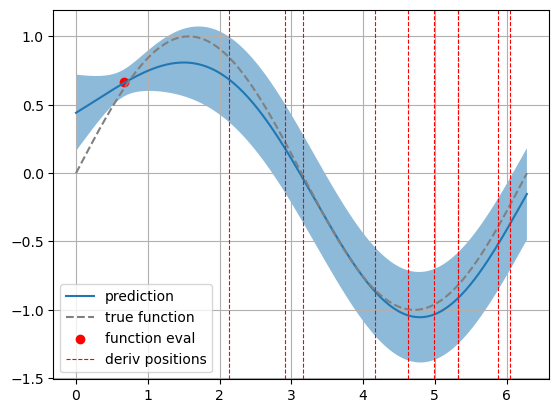

In [10]:
import matplotlib.pyplot as plt

plt.plot(predict_grid, means, label="prediction")
plt.fill_between(predict_grid, means-stds, means+stds, alpha=0.5)

plt.plot(predict_grid, sin(predict_grid), c="gray", ls="--",label="true function")

plt.scatter(x_func, y_func, c="r", label="function eval")
for i,x in enumerate(x_der): 
    if i == 0:
        plt.axvline(x, c="r", lw=0.8, ls="--", label="deriv positions")
    else:
        plt.axvline(x, c="r", lw=0.8, ls="--")

plt.grid()
plt.legend()

## The sparse GPR model

### Training the sparse GPR model

The `sparseGPR` model can be found in `jaxgp.regression`. The idea of a sparse model is to project your training data into a space with smaller dimension in order to save in computational cost. This is done by projecting your full training set onto a set of reference points via the kernel. Typically one simply projects the full dataset onto a smaller subset of the existing data.

In [11]:
from jaxgp.regression import SparseGPR

logger = Logger()

num_ref_points = (3,)
key, subkey = random.split(key)
X_ref = random.choice(subkey, x_der, num_ref_points)

model = SparseGPR(kernel, init_kernel_params, noise, X_ref, logger=logger)

In [12]:
model.train(X_split, Y_train)

OptStep(params=DeviceArray([1.2558753, 1.7300937], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-2.156128, dtype=float32, weak_type=True), success=True, status=0, iter_num=15))


Iterations of the parameters during optimization.

In [13]:
print(logger.iters_list)

[DeviceArray([[1.9840357, 1.8267119],
             [1.9739661, 1.7398057],
             [1.9708384, 1.7293595],
             [1.9699336, 1.7314782],
             [1.967236 , 1.732464 ],
             [1.9483268, 1.7357655],
             [1.9032818, 1.7397506],
             [1.7654531, 1.7464337],
             [1.4976461, 1.7523466],
             [1.271426 , 1.74937  ],
             [1.2342483, 1.7361794],
             [1.2714756, 1.7296124],
             [1.2537999, 1.7299968],
             [1.2558753, 1.7300937],
             [1.2558753, 1.7300937]], dtype=float32)]


### Making predictions with the trained model

We will again make predictions on an evenly spaced grid of 200 points in the above defined boundaries.

In [14]:
predict_grid = jnp.linspace(*bounds, 200)

# model.eval returns a mean prediction and a confidence interval around the mean prediction
means, stds = model.eval(predict_grid)

### Visualizing the result

Plotting the predicted function together with its confidence interval we can see that even with only a few datapoints the prediction works good. Close to the reference points the model works similar to the full GPR, however, far away the uncertainty get larger. The shaded region describes the $1\sigma$ confidence interval.

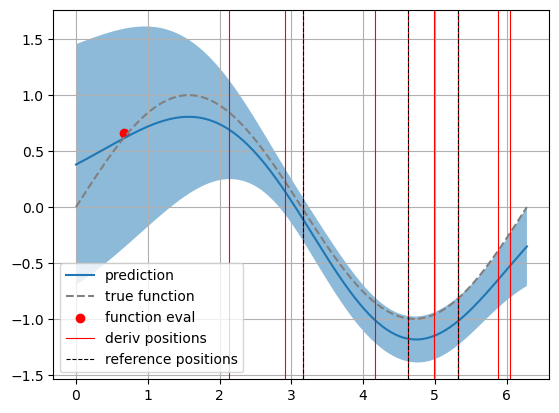

In [15]:
import matplotlib.pyplot as plt

plt.plot(predict_grid, means, label="prediction")
plt.fill_between(predict_grid, means-stds, means+stds, alpha=0.5)

plt.plot(predict_grid, sin(predict_grid), c="gray", ls="--",label="true function")

plt.scatter(x_func, y_func, c="r", label="function eval")
for i,x in enumerate(x_der): 
    if i == 0:
        plt.axvline(x, c="r", lw=0.8, ls="-", label="deriv positions")
    else:
        plt.axvline(x, c="r", lw=0.8, ls="-")

for i,x in enumerate(X_ref):
    if i == 0:
        plt.axvline(x, c="k", lw=0.8, ls="--", label="reference positions")
    else:
        plt.axvline(x, c="k", lw=0.8, ls="--")

plt.grid()
plt.legend()

### Comparing full and sparse GPR to a standard numerical integration via the trapezoidal rule

Now we repeat the datageneration as above on an evenly spaced grid.

In [16]:
# Define the data points at which to sample the function and its derivative
x_der = jnp.linspace(*bounds, *num_d_vals)
x_func = jnp.linspace(*bounds, *num_f_vals)

#create training data
X_split = [x_func.reshape(-1,1),x_der.reshape(-1,1)]

key, subkey = random.split(key)
y_func = sin(x_func,noise, subkey)
key, subkey = random.split(key)
y_der = cos(x_der, noise, subkey)

Y_train = jnp.hstack((y_func, y_der))

key, subkey = random.split(key)
X_ref = random.choice(subkey, x_der, num_ref_points)

We will also train the model again and predict values on the same grid as above.

In [17]:
model = ExactGPR(kernel, init_kernel_params, noise)
model.train(X_split, Y_train)

means_full, stds_full = model.eval(predict_grid)

model = SparseGPR(kernel, init_kernel_params, noise, X_ref)
model.train(X_split, Y_train)

means_sparse, stds_sparse = model.eval(predict_grid)

OptStep(params=DeviceArray([1.7233417, 2.2011442], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(1.916893, dtype=float32, weak_type=True), success=True, status=0, iter_num=8))
OptStep(params=DeviceArray([0.9415074, 1.1250604], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(10.490686, dtype=float32, weak_type=True), success=False, status=2, iter_num=18))


Now we use the trapezoidal rule to numerically integrate the same data.

In [18]:
trapsum = []
for i,elem in enumerate(y_der):
    trapsum.append(jnp.sum(y_der[:i+1]) - 0.5*(y_der[0] + y_der[i]))
trapsum = jnp.array(trapsum) * (x_der[1] - x_der[0])

# Add the function value at zero to fix the integration constant
trapsum += y_func

Plot the result for comparison. The shaded regions describe the $1\sigma$ confidence intervals around the mean prediction.

While the accuracy is comparable, the GPR produces a smooth fit and also gives a confidence interval around the prediction.

Comparing also the full GPR with the sparse GPR the fitted functions are similar, however, for the sparse version the confidence intervals are larger in between the reference points.

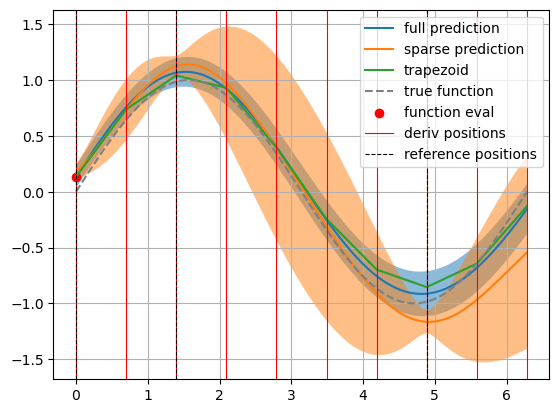

In [19]:
plt.plot(predict_grid, means_full, label="full prediction")
plt.fill_between(predict_grid, means_full-stds_full, means_full+stds_full, alpha=0.5)

plt.plot(predict_grid, means_sparse, label="sparse prediction")
plt.fill_between(predict_grid, means_sparse-stds_sparse, means_sparse+stds_sparse, alpha=0.5)

plt.plot(x_der,trapsum, label="trapezoid")

plt.plot(predict_grid, sin(predict_grid), c="gray", ls="--",label="true function")

plt.scatter(x_func, y_func, c="r", label="function eval")
for i,x in enumerate(x_der): 
    if i == 0:
        plt.axvline(x, c="r", lw=0.8, ls="-", label="deriv positions")
    else:
        plt.axvline(x, c="r", lw=0.8, ls="-")

for i,x in enumerate(X_ref):
    if i == 0:
        plt.axvline(x, c="k", lw=0.8, ls="--", label="reference positions")
    else:
        plt.axvline(x, c="k", lw=0.8, ls="--")

plt.grid()
plt.legend()